In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install mne

In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import math
import mne
import seaborn as sns
%matplotlib inline

In [4]:
epochs = mne.read_epochs('/content/drive/MyDrive/BCI/BCICompetition/data/Train_set/oddball_train_epo.fif')
epochs.info

Reading /content/drive/MyDrive/BCI/BCICompetition/data/Train_set/oddball_train_epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
3420 matching events found
No baseline correction applied
0 projection items activated


<Info | 10 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 15.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 240.0 Hz
>

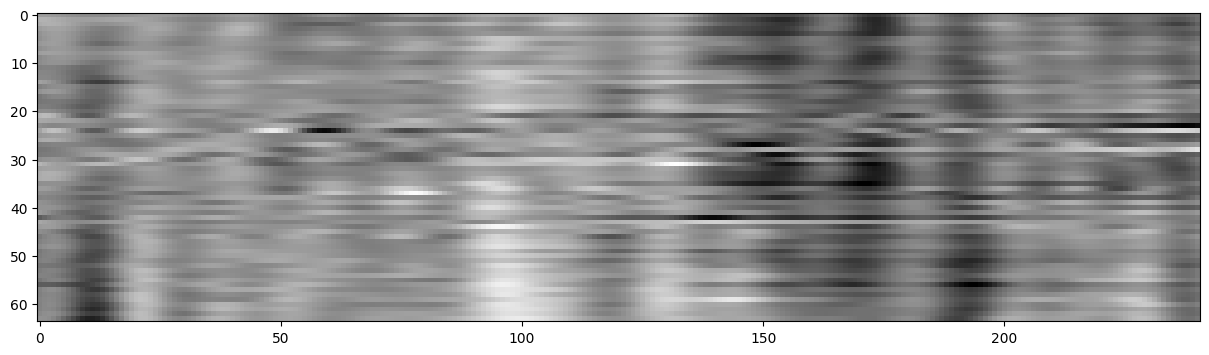

In [5]:
plt.figure(1, figsize=(15, 7))
plt.imshow(np.squeeze(epochs["P300"][6].get_data()), cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

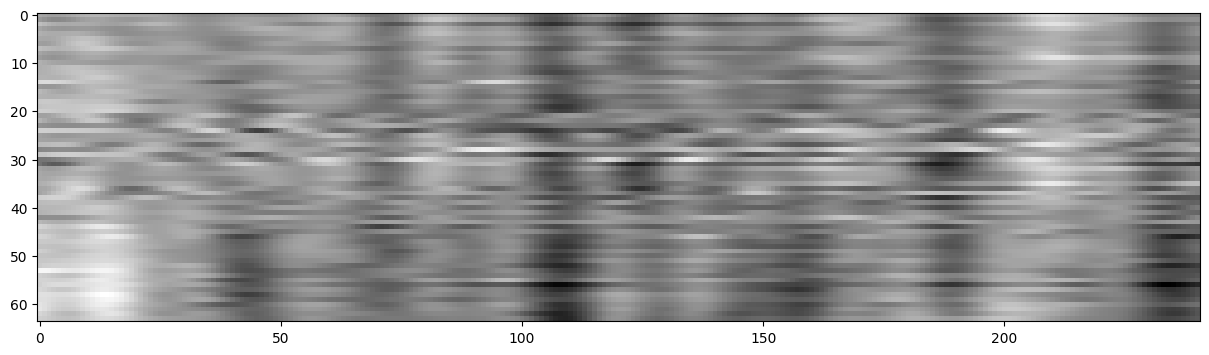

In [6]:
plt.figure(1, figsize=(15, 7))
plt.imshow(np.squeeze(epochs["NoP300"][6].get_data()), cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

In [7]:
target = epochs["P300"].pick_channels(['Oz','Cz','Pz'])#.average()
#target.get_data()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-7-ce5ca96ec337>:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  target = epochs["P300"].pick_channels(['Oz','Cz','Pz'])#.average()


In [8]:
standard = epochs["NoP300"].pick_channels(['Oz','Cz','Pz'])#.average()
standard

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-8-525529efa746>:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  standard = epochs["NoP300"].pick_channels(['Oz','Cz','Pz'])#.average()


Number of events,2850
Events,NoP300: 2850
Time range,-0.300 – 0.700 s
Baseline,-0.300 – 0.000 s


In [9]:
def ventanas_mean(epochs,m1,m2,m3,m4,F):
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.mean(data_part1[:, :], axis=2)
  mean_part2 = np.mean(data_part2[:, :], axis=2)
  mean_part3 = np.mean(data_part3[:, :], axis=2)
  mean_part4 = np.mean(data_part4[:, :], axis=2)
  return mean_part1, mean_part2, mean_part3, mean_part4

In [10]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_mean(target,-0.3,0,0.25,0.4,0.7)
mean_target_part1.shape, mean_target_part2.shape ,mean_target_part3.shape ,mean_target_part4.shape

((570, 3), (570, 3), (570, 3), (570, 3))

In [11]:
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_mean(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape, mean_standard_part2.shape, mean_standard_part3.shape, mean_standard_part4.shape

((2850, 3), (2850, 3), (2850, 3), (2850, 3))

In [12]:
print(mean_target_part1.shape)
print(mean_standard_part1.shape)
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
print(featuresT.shape)
print(featuresF.shape)

(570, 3)
(2850, 3)
(570, 12)
(2850, 12)


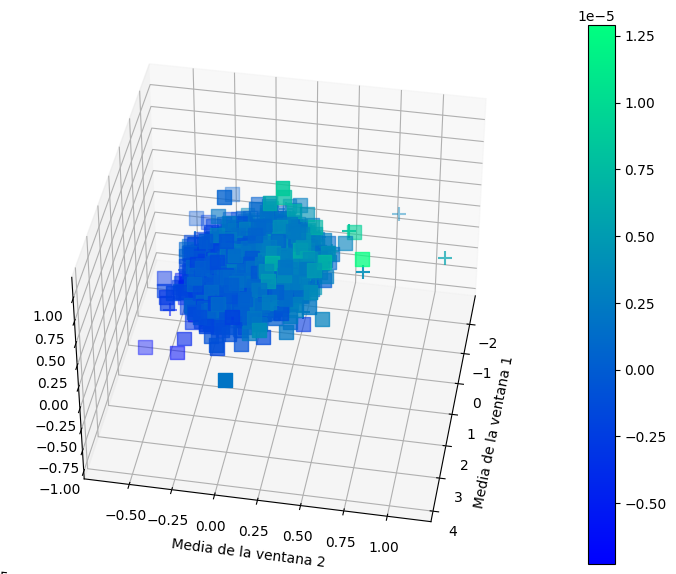

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = mean_target_part1
y = mean_target_part2
z = mean_target_part4
c = mean_target_part3

x1 = mean_standard_part1
y1 = mean_standard_part2
z1 = mean_standard_part4
c1 = mean_standard_part3

img2 = ax.scatter(x1, y1, z1, c=c1, s = 100, marker = "s", cmap=plt.winter())
fig.colorbar(img2)

plt.xlabel('Media de la ventana 1')
plt.ylabel('Media de la ventana 2')
plt.clabel('Media de la ventana 3')


img = ax.scatter(x, y, z, c=c, s = 100,marker = "+", cmap=plt.winter())
ax.view_init(40, 10)
#fig.colorbar(img,img2)
plt.show()

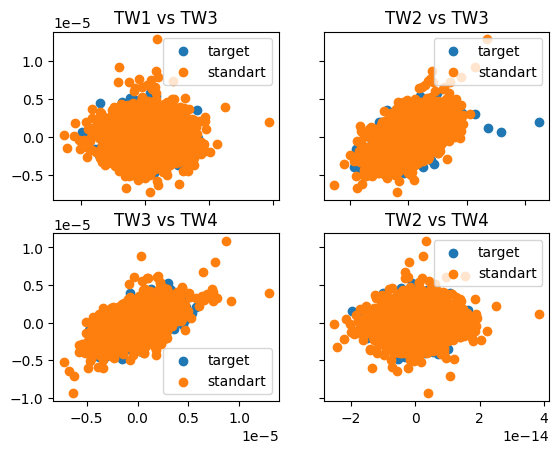

In [14]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(mean_target_part1,mean_target_part3, label = 'target')
axs[0, 0].scatter(mean_standard_part1,mean_standard_part3, label = 'standart')
axs[0, 0].set_title('TW1 vs TW3')
axs[0, 0].legend()
axs[0, 1].scatter(mean_target_part2,mean_target_part3, label = 'target')
axs[0, 1].scatter(mean_standard_part2,mean_standard_part3, label = 'standart')
axs[0, 1].set_title('TW2 vs TW3')
axs[0, 1].legend()
axs[1, 0].scatter(mean_target_part3, mean_target_part4, label = 'target')
axs[1, 0].scatter(mean_standard_part3, mean_standard_part4, label = 'standart')
axs[1, 0].set_title('TW3 vs TW4')
axs[1, 0].legend()
axs[1, 1].scatter(mean_target_part1,mean_target_part4, label = 'target')
axs[1, 1].scatter(mean_standard_part1,mean_standard_part4, label = 'standart')
axs[1, 1].set_title('TW2 vs TW4')
axs[1, 1].legend()


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

570


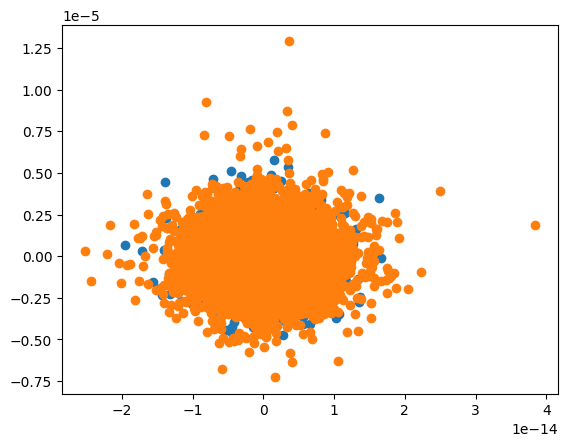

In [15]:
print(len(mean_target_part1))
plt.scatter(mean_target_part1,mean_target_part3)
plt.scatter(mean_standard_part1,mean_standard_part3)

In [16]:
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])
print(labelT.shape)
print(labelF.shape)

(570,)
(2850,)


In [17]:
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(3420, 12)
(3420,)


In [18]:
import seaborn as sns
data_df = pd.DataFrame(features)
#data_df.columns = ["M ventana 1", "M ventana 2", "M ventana 3","M ventana 4"]
data_df['P300'] =labels


In [19]:
sns.pairplot(data_df, hue="P300")

Output hidden; open in https://colab.research.google.com to view.

In [20]:
#from sklearn.feature_selection import VarianceThreshold
#sel = VarianceThreshold(threshold=(.8 * (1 - .8))) # la varianza para una distribucción binomial es Var(x)=p(1-p)
#sel.fit_transform(data_df)

In [21]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_classif
#X_new = SelectKBest(f_classif, k=64).fit_transform(X, y) # Utiliza f_test para clasificación
#X_new

In [22]:
#from sklearn.feature_selection import SelectKBest, f_classif

#selector = SelectKBest(f_classif, k=64)
#selector.fit(X_train, y_train)
#scores = -np.log10(selector.pvalues_)
#scores /= scores.max()

## Electrodos promediados

In [23]:
epochs = mne.read_epochs('/content/drive/MyDrive/BCI/BCICompetition/data/Train_set/elect_mean_epo.fif')
epochs.info

Reading /content/drive/MyDrive/BCI/BCICompetition/data/Train_set/elect_mean_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -304.00 ...     696.00 ms
        0 CTF compensation matrices available
Not setting metadata
1140 matching events found
No baseline correction applied
0 projection items activated


<Info | 9 non-empty values
 bads: []
 ch_names: O, C, P
 chs: 3 EEG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 3
 projs: []
 sfreq: 125.0 Hz
>

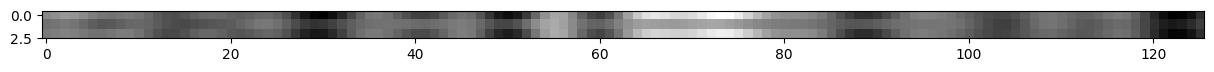

In [24]:
plt.figure(1, figsize=(15, 7))
plt.imshow(np.squeeze(epochs["1"][1].get_data()), cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

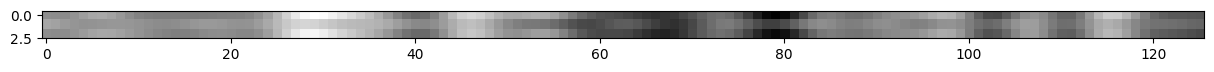

In [25]:
plt.figure(1, figsize=(15, 7))
plt.imshow(np.squeeze(epochs["0"][6].get_data()), cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

In [26]:
target = epochs["1"]#.average()
#target.get_data()

In [27]:
standard = epochs["0"]#.average()
standard

Number of events,570
Events,0: 570
Time range,-0.304 – 0.696 s
Baseline,off


In [28]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_mean(target,-0.3,0,0.25,0.4,0.7)
mean_target_part1.shape, mean_target_part2.shape ,mean_target_part3.shape ,mean_target_part4.shape

<ipython-input-9-6e71144bfdca>:5: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


((570, 3), (570, 3), (570, 3), (570, 3))

In [29]:
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_mean(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape, mean_standard_part2.shape, mean_standard_part3.shape, mean_standard_part4.shape

<ipython-input-9-6e71144bfdca>:5: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


((570, 3), (570, 3), (570, 3), (570, 3))

In [30]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)

In [31]:
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])

In [32]:
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(1140, 12)
(1140,)


In [33]:
data_df = pd.DataFrame(features)
data_df['P300'] =labels

In [34]:
sns.pairplot(data_df, hue="P300")

Output hidden; open in https://colab.research.google.com to view.

## Electrodos promediados cuadrados

In [35]:
def ventanas_exp2(epochs,m1,m2,m3,m4,F):
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.mean(data_part1[:, :]**2, axis=2)
  mean_part2 = np.mean(data_part2[:, :]**2, axis=2)
  mean_part3 = np.mean(data_part3[:, :]**2, axis=2)
  mean_part4 = np.mean(data_part4[:, :]**2, axis=2)
  return mean_part1, mean_part2, mean_part3, mean_part4

In [36]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_exp2(target,-0.3,0,0.25,0.4,0.7)

<ipython-input-35-a806944368ba>:5: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


In [37]:
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_mean(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape

<ipython-input-9-6e71144bfdca>:5: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


(570, 3)

In [38]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])

In [39]:
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(1140, 12)
(1140,)


In [40]:
data_df = pd.DataFrame(features)
data_df['P300'] =labels

In [41]:
sns.pairplot(data_df, hue="P300")

Output hidden; open in https://colab.research.google.com to view.

## Rango Intercuartil

In [42]:
def ventanas_IQR(epochs,m1,m2,m3,m4,F):
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.percentile(data_part1[:, :],75, axis=2)-np.percentile(data_part1[:, :],25, axis=2)
  mean_part2 = np.percentile(data_part2[:, :],75, axis=2)-np.percentile(data_part2[:, :],25, axis=2)
  mean_part3 = np.percentile(data_part3[:, :],75, axis=2)-np.percentile(data_part3[:, :],25, axis=2)
  mean_part4 = np.percentile(data_part4[:, :],75, axis=2)-np.percentile(data_part4[:, :],25, axis=2)
  return mean_part1, mean_part2, mean_part3, mean_part4

In [43]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_IQR(target,-0.3,0,0.25,0.4,0.7)
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_IQR(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape

<ipython-input-42-db9ed395834d>:5: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
<ipython-input-42-db9ed395834d>:5: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


(570, 3)

In [44]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])

In [45]:
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(1140, 12)
(1140,)


In [46]:
data_df = pd.DataFrame(features)
data_df['P300'] =labels

In [47]:
sns.pairplot(data_df, hue="P300")

Output hidden; open in https://colab.research.google.com to view.

## Desviación estandar

In [48]:
def ventanas_STR(epochs,m1,m2,m3,m4,F):
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.std(data_part1[:, :], axis=2)
  mean_part2 = np.std(data_part2[:, :], axis=2)
  mean_part3 = np.std(data_part3[:, :], axis=2)
  mean_part4 = np.std(data_part4[:, :], axis=2)
  return mean_part1, mean_part2, mean_part3, mean_part4

In [49]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_STR(target,-0.3,0,0.25,0.4,0.7)
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_STR(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape

<ipython-input-48-f5938f916751>:5: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
<ipython-input-48-f5938f916751>:5: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


(570, 3)

In [50]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(1140, 12)
(1140,)


In [51]:
data_df = pd.DataFrame(features)
data_df['P300'] =labels

In [52]:
sns.pairplot(data_df, hue="P300")

Output hidden; open in https://colab.research.google.com to view.

## Desviación máxima

In [53]:
def ventanas_maxSTR(epochs,m1,m2,m3,m4,F):
  std = np.std(epochs.get_data())
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.max(data_part1[:, :], axis=2)/std
  mean_part2 = np.max(data_part2[:, :], axis=2)/std
  mean_part3 = np.max(data_part3[:, :], axis=2)/std
  mean_part4 = np.max(data_part4[:, :], axis=2)/std
  return mean_part1, mean_part2, mean_part3, mean_part4

In [54]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_maxSTR(target,-0.3,0,0.25,0.4,0.7)
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_maxSTR(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape

<ipython-input-53-ce5d1eba5bab>:6: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
<ipython-input-53-ce5d1eba5bab>:6: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


(570, 3)

In [55]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])

In [56]:
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(1140, 12)
(1140,)


In [57]:
data_df = pd.DataFrame(features)
data_df['P300'] =labels

In [58]:
sns.pairplot(data_df, hue="P300")

Output hidden; open in https://colab.research.google.com to view.

## Coeficiente de Variación

In [59]:
def ventanas_CV(epochs,m1,m2,m3,m4,F):
  prom = np.mean(epochs.get_data()) # Si pongo este parametro la distribución cambia   , axis=2
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.std(data_part1[:, :], axis=2)/prom
  mean_part2 = np.std(data_part2[:, :], axis=2)/prom
  mean_part3 = np.std(data_part3[:, :], axis=2)/prom
  mean_part4 = np.std(data_part4[:, :], axis=2)/prom
  return mean_part1, mean_part2, mean_part3, mean_part4

In [60]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_CV(target,-0.3,0,0.25,0.4,0.7)
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_CV(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape

<ipython-input-59-c791974f6235>:6: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
<ipython-input-59-c791974f6235>:6: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


(570, 3)

In [61]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])

In [62]:
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(1140, 12)
(1140,)


In [63]:
data_df = pd.DataFrame(features)
data_df['P300'] =labels

In [64]:
sns.pairplot(data_df, hue="P300")

Output hidden; open in https://colab.research.google.com to view.

## Coeficiente de Variación por Ventana

In [65]:
def ventanas_WindCV(epochs,m1,m2,m3,m4,F):
  prom = np.mean(epochs.get_data()) # Si pongo este parametro la distribución cambia   , axis=2
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.std(data_part1[:, :], axis=2)/np.mean(data_part1[:, :], axis=2)
  mean_part2 = np.std(data_part2[:, :], axis=2)/np.mean(data_part2[:, :], axis=2)
  mean_part3 = np.std(data_part3[:, :], axis=2)/np.mean(data_part3[:, :], axis=2)
  mean_part4 = np.std(data_part4[:, :], axis=2)/np.mean(data_part4[:, :], axis=2)
  return mean_part1, mean_part2, mean_part3, mean_part4

In [66]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_WindCV(target,-0.3,0,0.25,0.4,0.7)
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_WindCV(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape

<ipython-input-65-9d491302188d>:6: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
<ipython-input-65-9d491302188d>:6: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.696 s)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


(570, 3)

In [67]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(1140, 12)
(1140,)


In [68]:
data_df = pd.DataFrame(features)
data_df['P300'] =labels

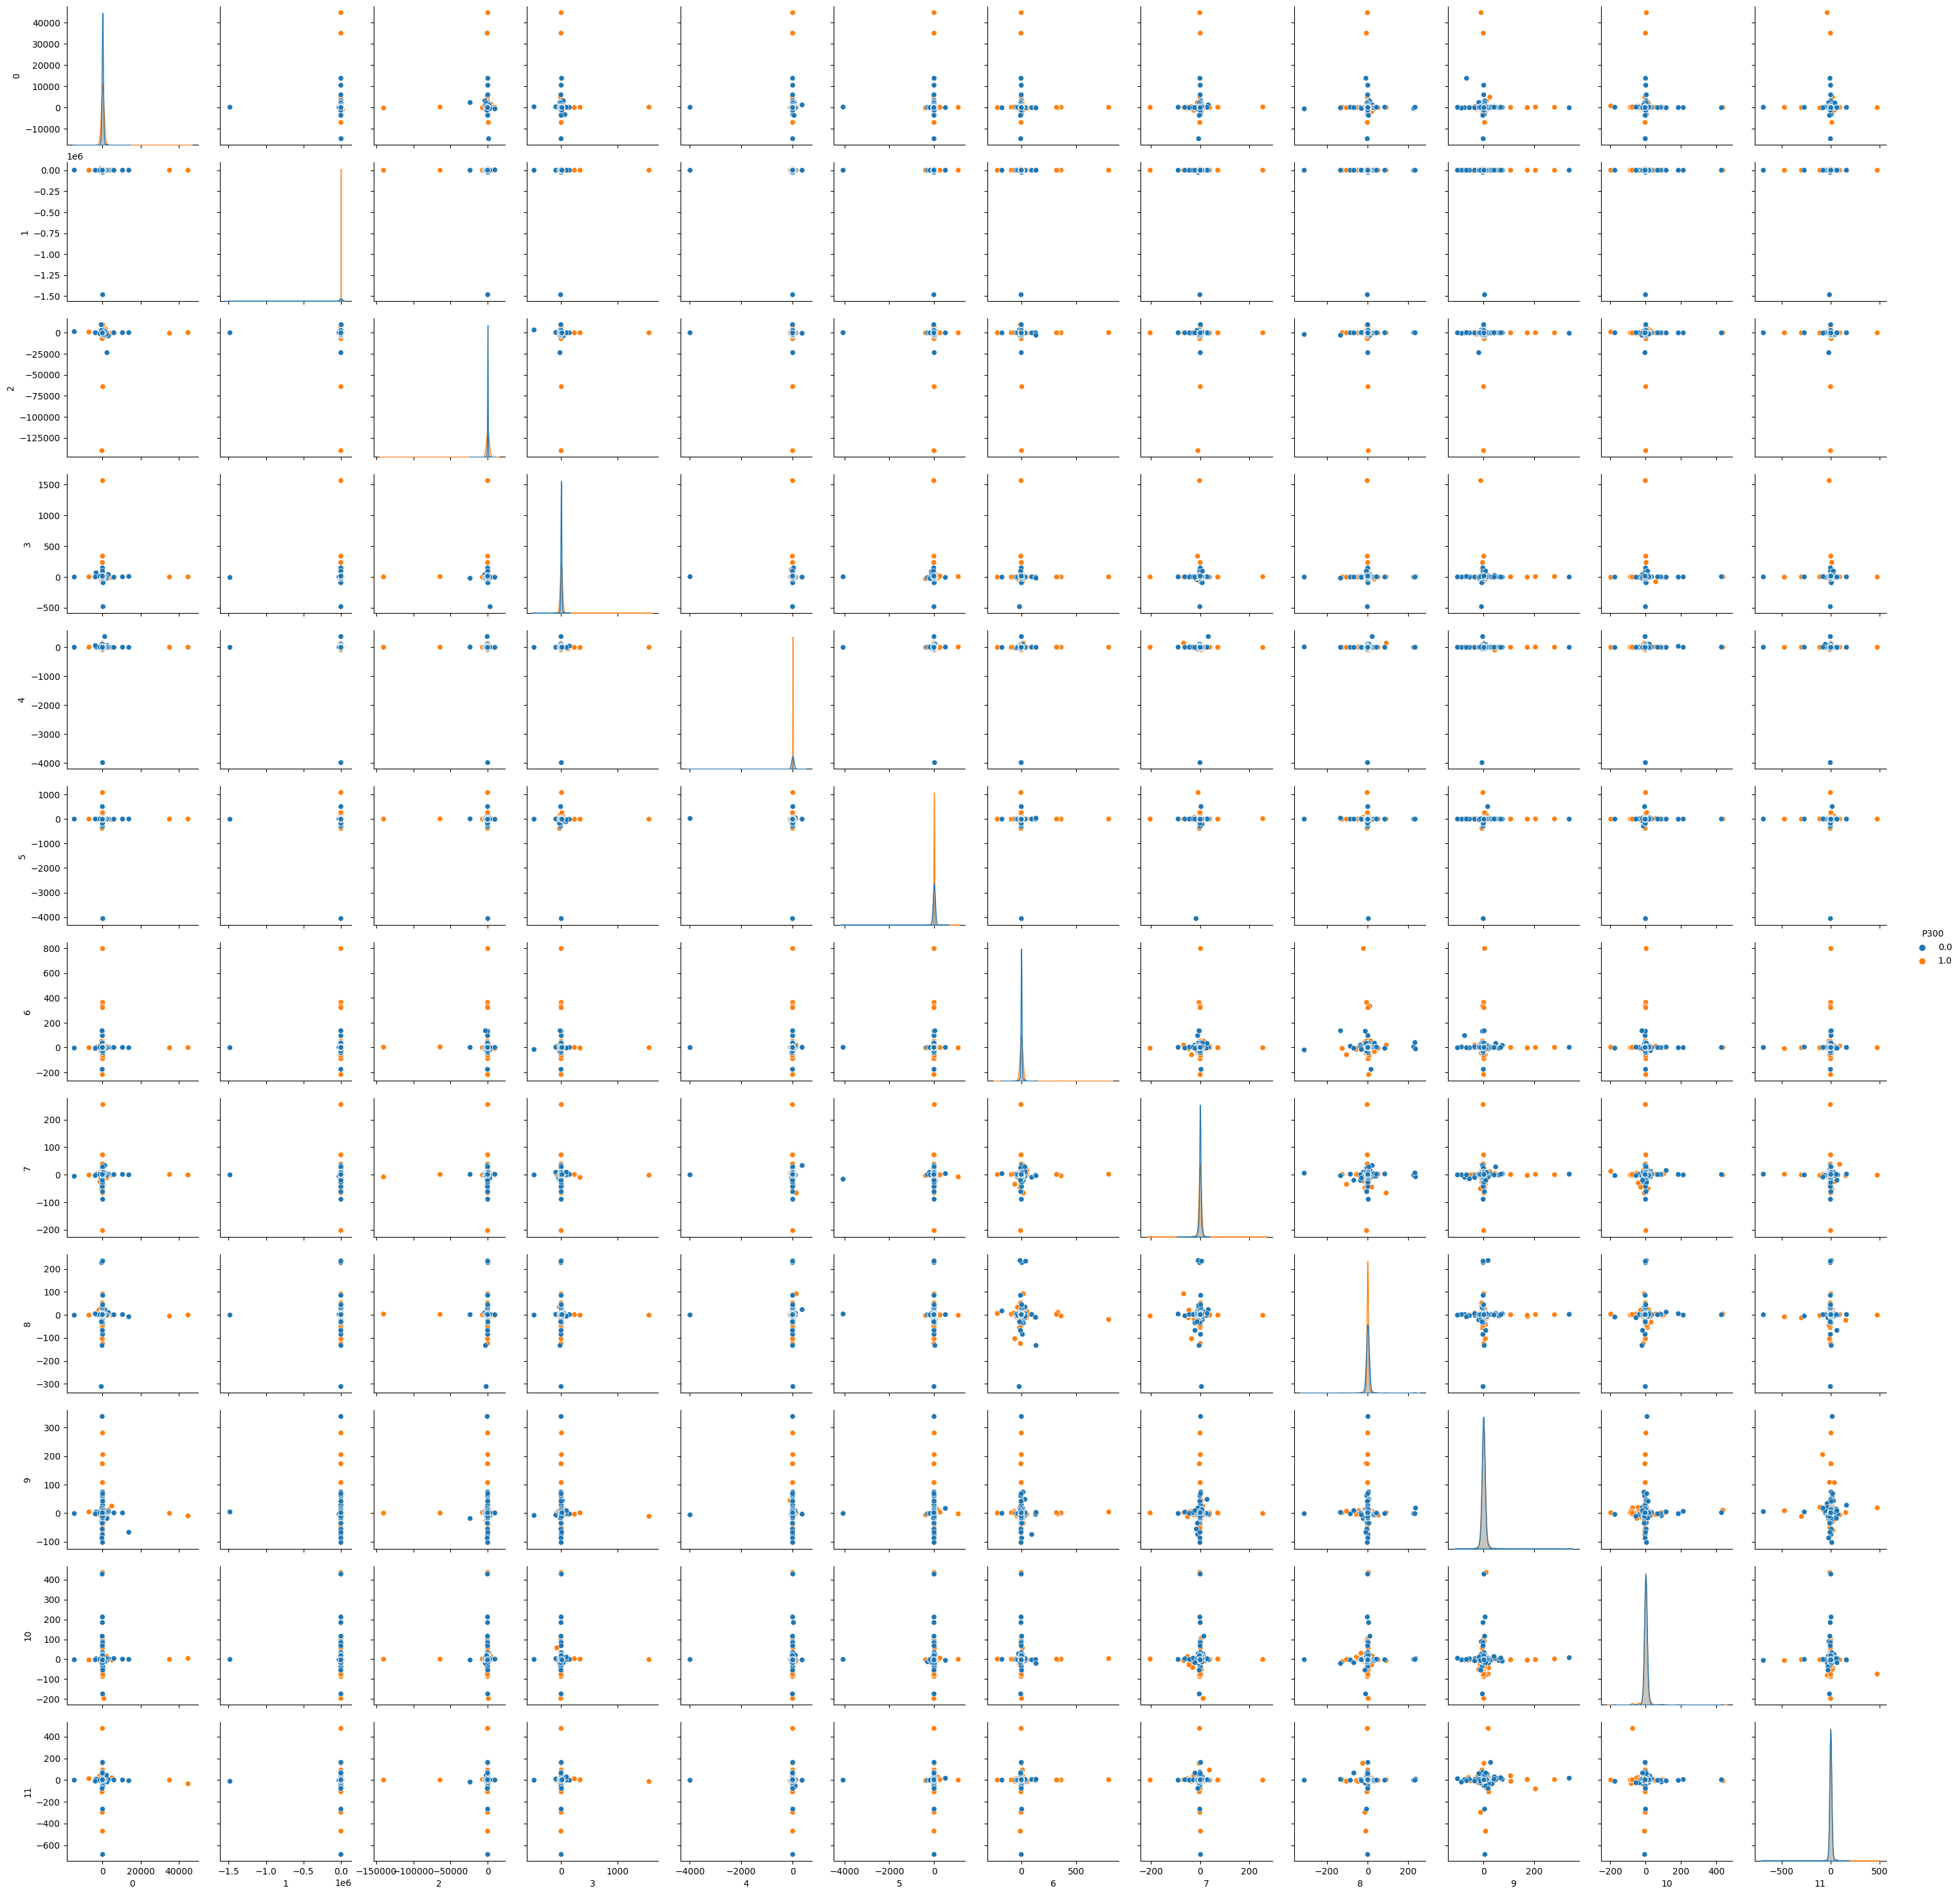

In [69]:
sns.pairplot(data_df, hue="P300")